<a href="https://colab.research.google.com/github/deawonyun/FirstProject/blob/master/BrainTumorMRIDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from datetime import datetime
import os, glob, shutil, zipfile, random

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical

In [2]:
from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
with zipfile.ZipFile("/content/gdrive/MyDrive/Colab Notebooks/data/archive.zip", "r") as target_file:
    target_file.extractall("/content/brain_tumor/")

In [6]:
train_data_gen = ImageDataGenerator(rescale=1./255., 
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1)

test_data_gen = ImageDataGenerator(rescale=1./255.)

In [21]:
train_dir = "/content/brain_tumor/Training"
test_dir = "/content/brain_tumor/Testing"

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
train_data = train_data_gen.flow_from_directory(train_dir,
                                                batch_size=32,
                                                color_mode="rgb",
                                                shuffle=True,
                                                class_mode="sparse",
                                                target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))

test_data = test_data_gen.flow_from_directory(test_dir,
                                                batch_size=32,
                                                color_mode="rgb",
                                                shuffle=True,
                                                class_mode="sparse",
                                                target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [22]:
print(train_data.class_indices.items())
print(train_data.num_classes)

print(test_data.class_indices)
print(test_data.num_classes)

dict_items([('glioma', 0), ('meningioma', 1), ('notumor', 2), ('pituitary', 3)])
4
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
4


In [23]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [24]:
# FC 계층 모델
model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(4, activation="softmax"))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 16)                32784     
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 68        
                                                                 
Total params: 20,894,332
Trainable params: 20,839,804
Non-trainable params: 54,528
_____________________________________

In [25]:
model.compile(loss='sparse_categorical_crossentropy', 
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['acc'])

from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './brain_tumor_MRI_v1.h5'

checkpoint = ModelCheckpoint(save_file_name,       # file명을 지정
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출
                             verbose=1,            # 로그를 출력
                             save_best_only=True,  # 가장 best 값만 저장
                             mode='auto'           # auto는 알아서 best를 찾음
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,          # 5회 Epoch동안 개선되지 않는다면 종료
                             )


start_time = datetime.now()

hist = model.fit(train_data, epochs=20, 
                 validation_data=test_data)

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

# loss: 0.0484 - acc: 0.9865 - val_loss: 0.0343 - val_acc: 0.9893

Epoch 1/20
179/179 [==============================] - 133s 699ms/step - loss: 1.0344 - acc: 0.6127 - val_loss: 0.8164 - val_acc: 0.6880
Epoch 2/20
179/179 [==============================] - 118s 656ms/step - loss: 0.5643 - acc: 0.8253 - val_loss: 0.7096 - val_acc: 0.7101
Epoch 3/20
179/179 [==============================] - 121s 676ms/step - loss: 0.3846 - acc: 0.8888 - val_loss: 0.4243 - val_acc: 0.8482
Epoch 4/20
179/179 [==============================] - 118s 656ms/step - loss: 0.3056 - acc: 0.9065 - val_loss: 0.2440 - val_acc: 0.9184
Epoch 5/20
179/179 [==============================] - 121s 677ms/step - loss: 0.2602 - acc: 0.9249 - val_loss: 0.1847 - val_acc: 0.9367
Epoch 6/20
179/179 [==============================] - 119s 663ms/step - loss: 0.2147 - acc: 0.9368 - val_loss: 0.1546 - val_acc: 0.9489
Epoch 7/20
179/179 [==============================] - 122s 677ms/step - loss: 0.1753 - acc: 0.9513 - val_loss: 0.1274 - val_acc: 0.9603
Epoch 8/20
179/179 [============================

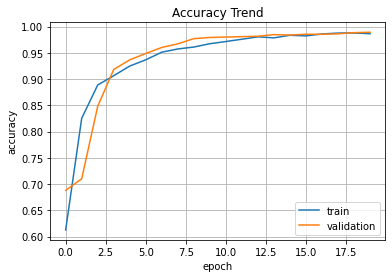

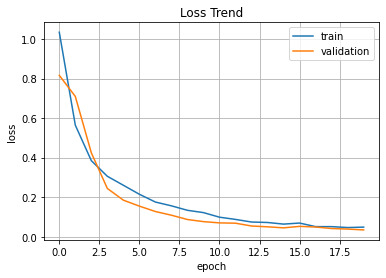

In [27]:
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [29]:
model.evaluate(test_data)

# loss: 0.0343 - acc: 0.9893
# [0.03429693356156349, 0.9893211126327515]

41/41 [==============================] - 6s 147ms/step - loss: 0.0343 - acc: 0.9893


[0.03429693356156349, 0.9893211126327515]